In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reconstruct import DiscreteWindowedRampFilter
from shepp_logan import shepp_logan
from project import acquire_projections

In [2]:
n_pixels = 1001
n_projections = 1200
tau = 0.1

phantom = shepp_logan(n_pixels)
sinogram = acquire_projections(phantom, n_projections=n_projections)


Text(0.5, 1.0, 'Projection at Theta=0º')

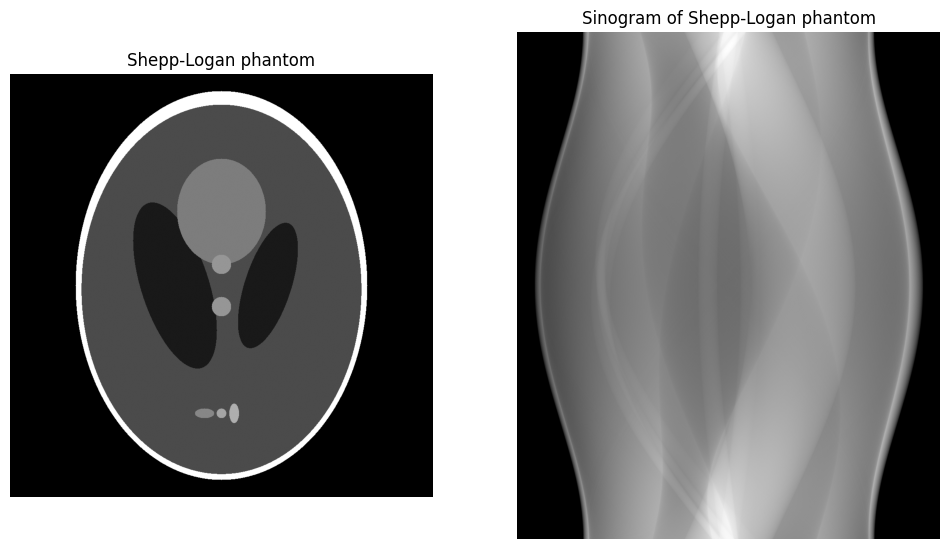

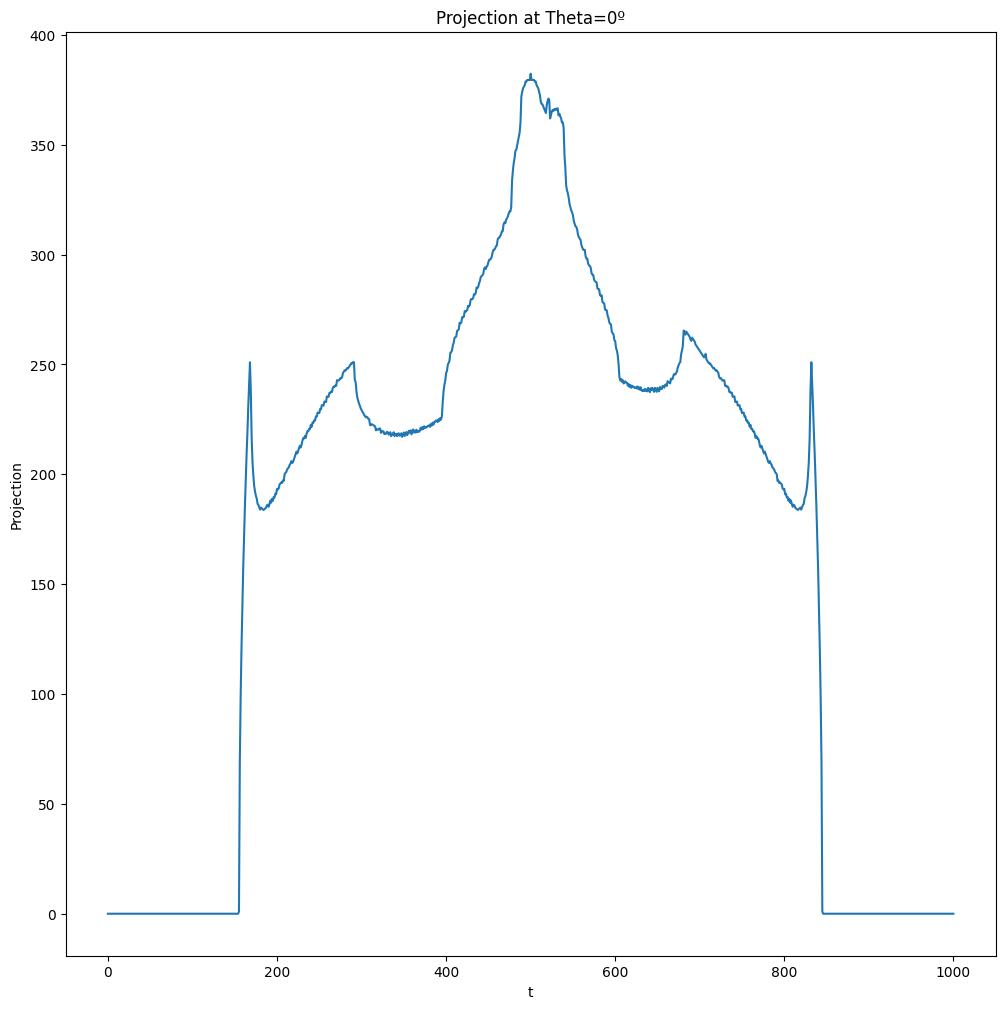

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12, 24))

axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Shepp-Logan phantom")
axs[0].axis("off")

axs[1].imshow(sinogram, cmap="gray")
axs[1].set_title("Sinogram of Shepp-Logan phantom")
axs[1].axis("off")

fig, ax = plt.subplots(1,1, figsize=(12, 12))
ax.plot(sinogram[0])
ax.set_xlabel("t")
ax.set_ylabel("Projection")

ax.set_title("Projection at Theta=0º")

c:\Users\altp\CT_recon\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\altp\CT_recon\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$t$')

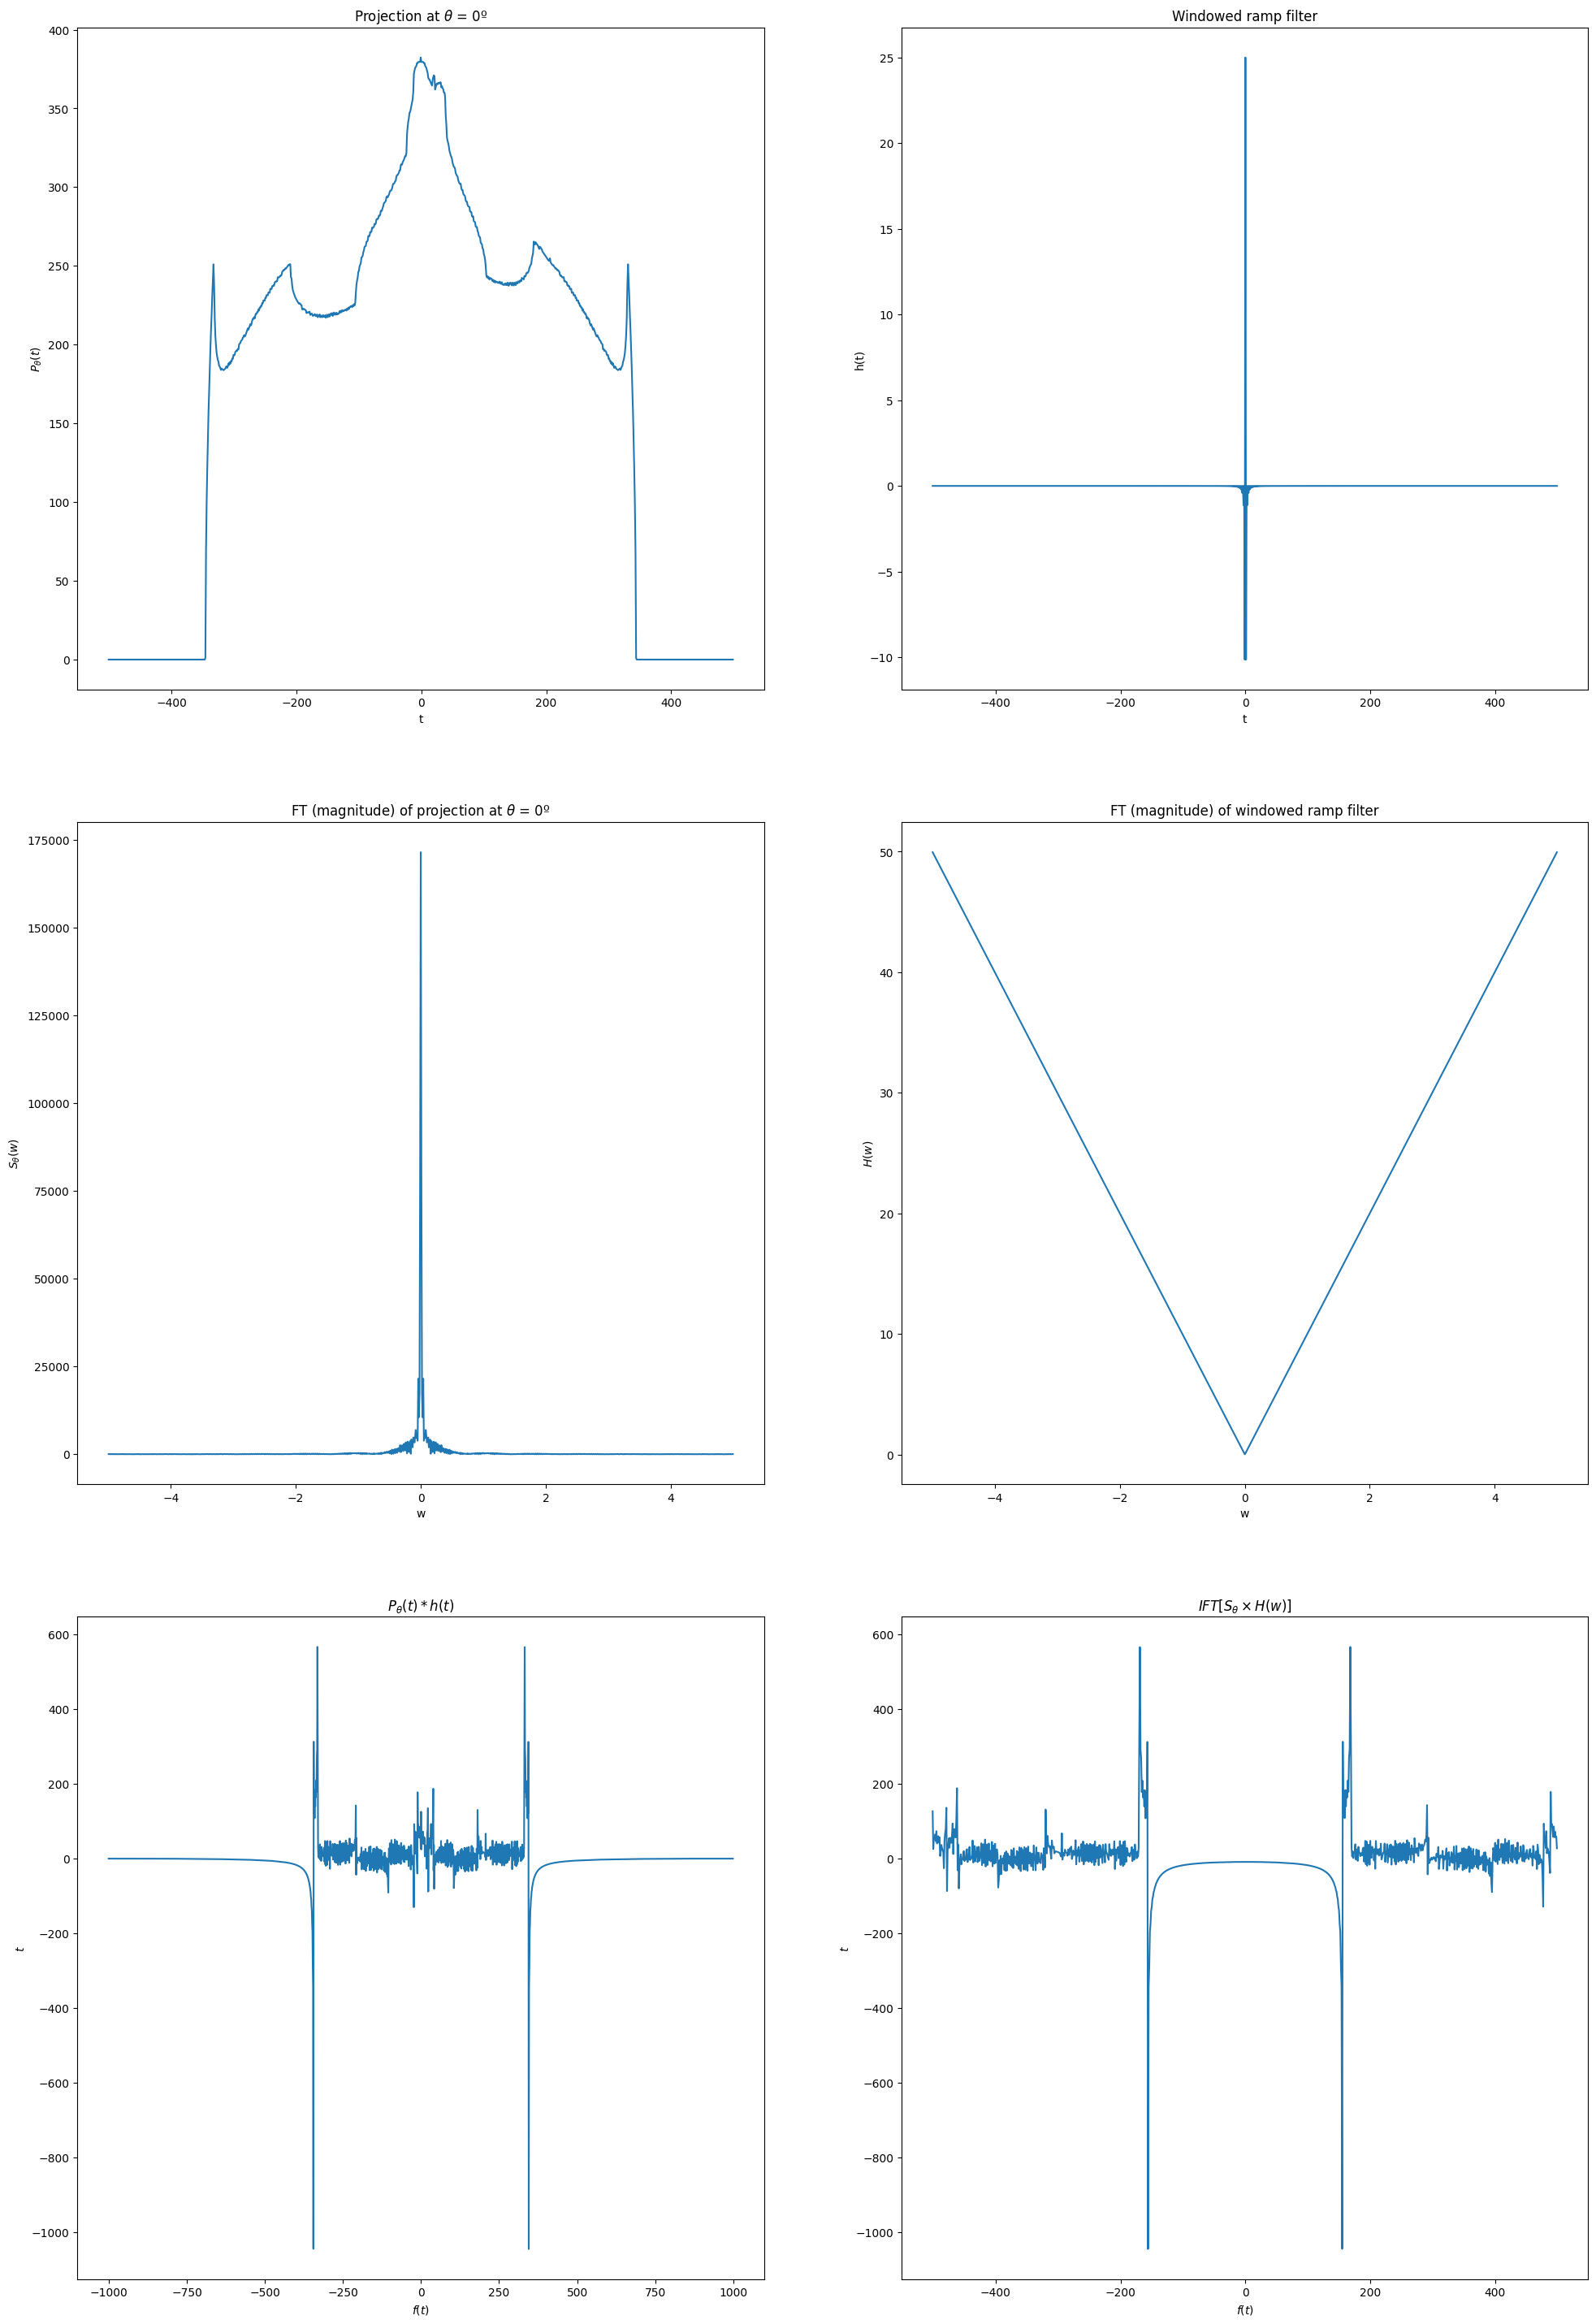

In [4]:
t = np.arange(-n_pixels // 2, n_pixels // 2)

filter = DiscreteWindowedRampFilter(tau)
h_t = filter(t)

P_0 = sinogram[0]

S_0 = np.fft.fftshift(np.fft.fft(P_0))
H_w = np.fft.fftshift(np.fft.fft(h_t))

w = np.fft.fftshift(np.fft.fftfreq(1001, d=tau))

convolution = np.convolve(P_0, h_t)
t_conv = np.arange(-len(convolution) // 2, len(convolution) // 2)

multiplication = np.fft.ifft(np.fft.ifftshift(S_0 * H_w))

fig, axs = plt.subplots(3, 2, figsize=(24, 36))

axs[0,0].plot(t, P_0)
axs[0,0].set_title("Projection at $\\theta$ = 0º")
axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel("$P_\\theta (t)$")

axs[0,1].plot(t, h_t)
axs[0,1].set_title("Windowed ramp filter")
axs[0,1].set_xlabel("t")
axs[0,1].set_ylabel("h(t)")

axs[1,0].plot(w, np.abs(S_0))
axs[1,0].set_title("FT (magnitude) of projection at $\\theta$ = 0º")
axs[1,0].set_xlabel("w")
axs[1,0].set_ylabel("$S_{\\theta}(w)$")

axs[1,1].plot(w, np.abs(H_w))
axs[1,1].set_title("FT (magnitude) of windowed ramp filter")
axs[1,1].set_xlabel("w")
axs[1,1].set_ylabel("$H(w)$")

axs[2,0].plot(t_conv, convolution)
axs[2,0].set_title("$P_\\theta (t) * h(t)$")
axs[2,0].set_xlabel("$f(t)$")
axs[2,0].set_ylabel("$t$")

axs[2,1].plot(t, multiplication)
axs[2,1].set_title("$IFT[S_{\\theta} \\times H(w)]$")
axs[2,1].set_xlabel("$f(t)$")
axs[2,1].set_ylabel("$t$")



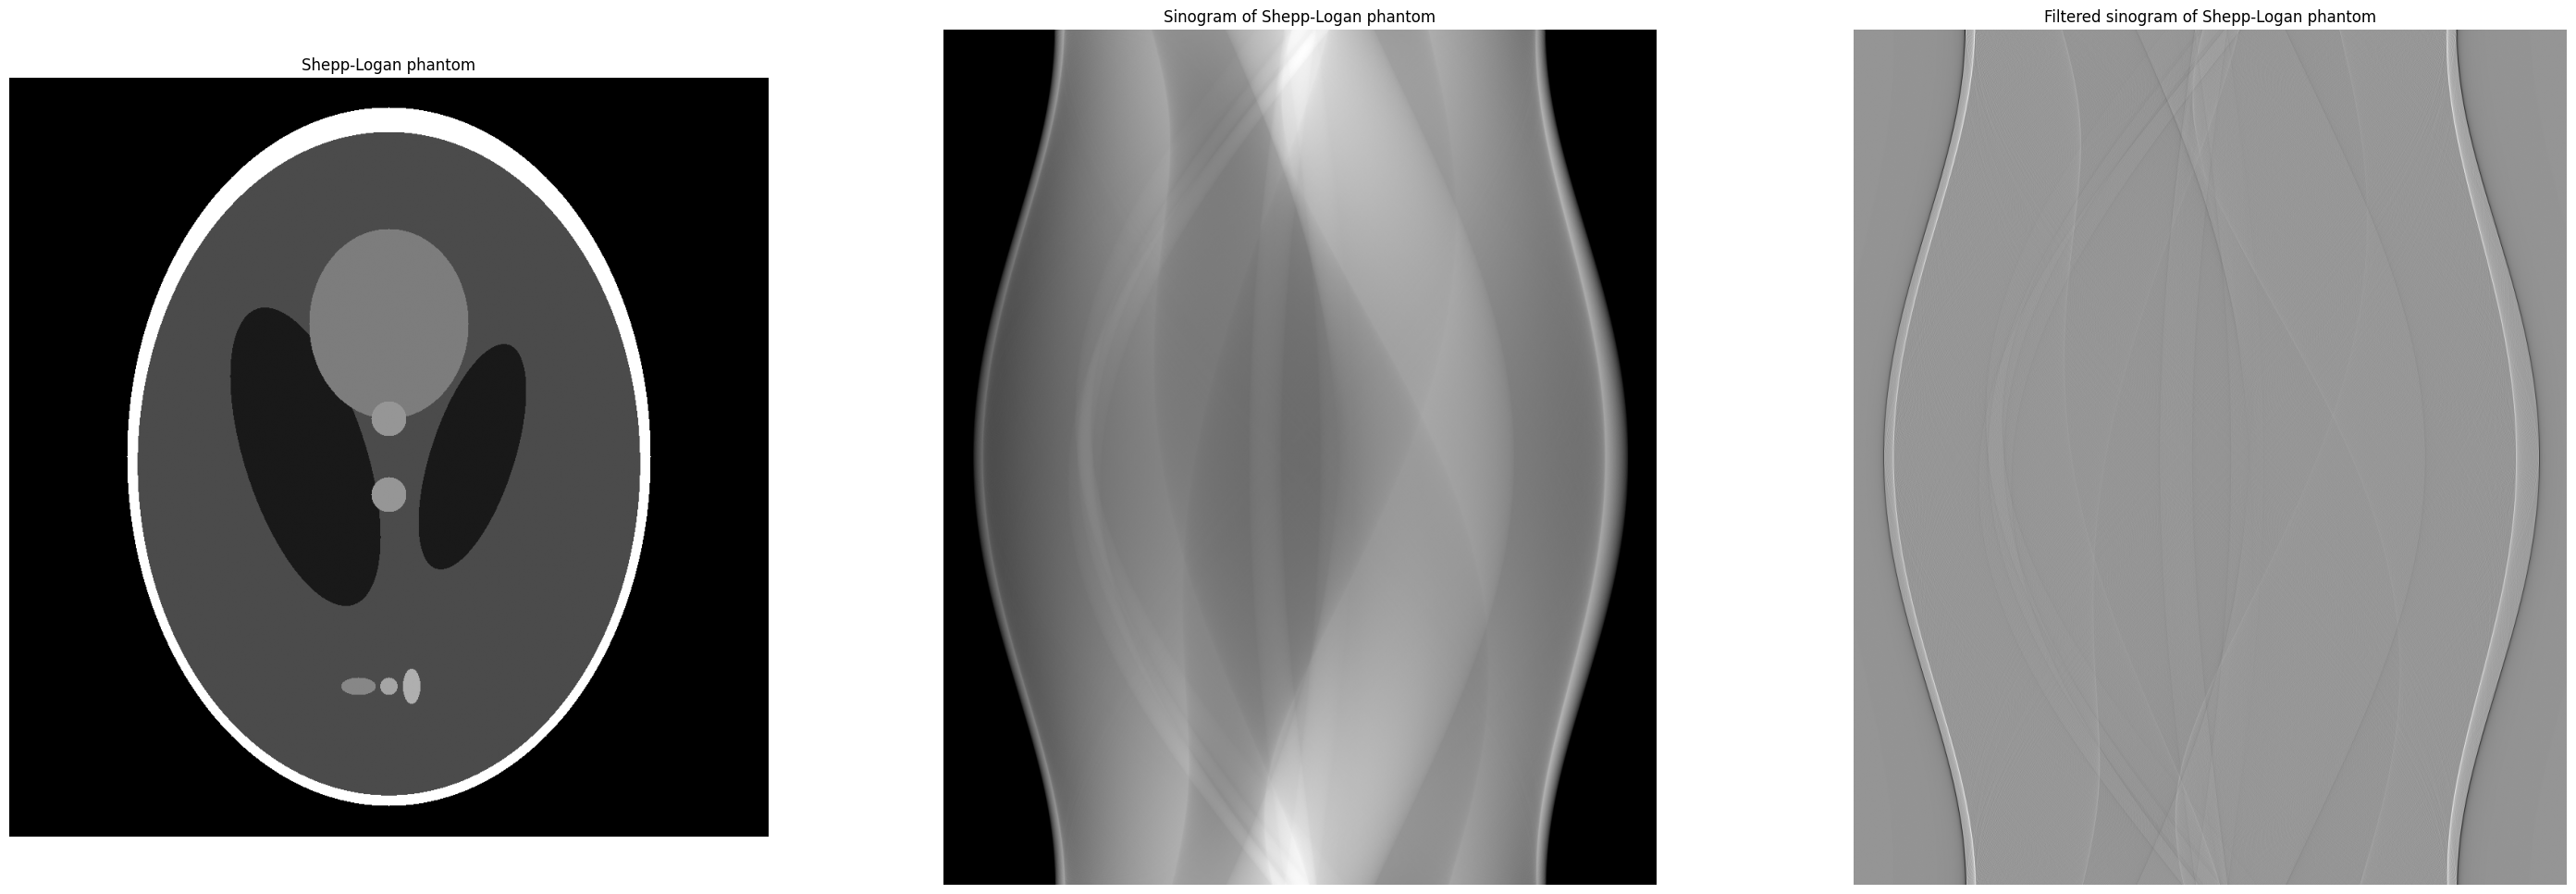

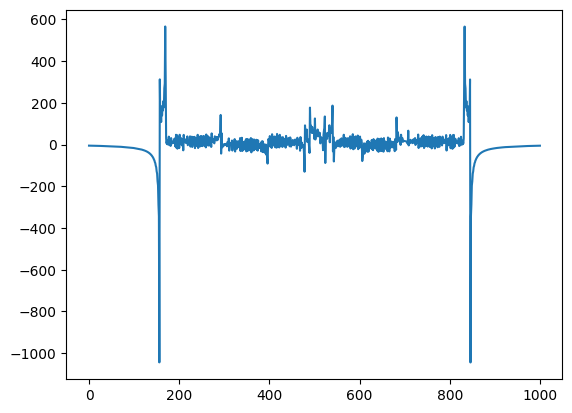

In [5]:
from scipy import signal

fig, axs = plt.subplots(1,3, figsize=(36, 12))

axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Shepp-Logan phantom")
axs[0].axis("off")

axs[1].imshow(sinogram, cmap="gray")
axs[1].set_title("Sinogram of Shepp-Logan phantom")
axs[1].axis("off")

filtered_sinogram = signal.convolve(sinogram, h_t.reshape(1, -1), mode="same", method="auto")
axs[2].imshow(filtered_sinogram, cmap="gray")
axs[2].set_title("Filtered sinogram of Shepp-Logan phantom")
axs[2].axis("off")

plt.show()

plt.plot(filtered_sinogram[0])

(np.float64(-0.5), np.float64(1000.5), np.float64(1199.5), np.float64(-0.5))

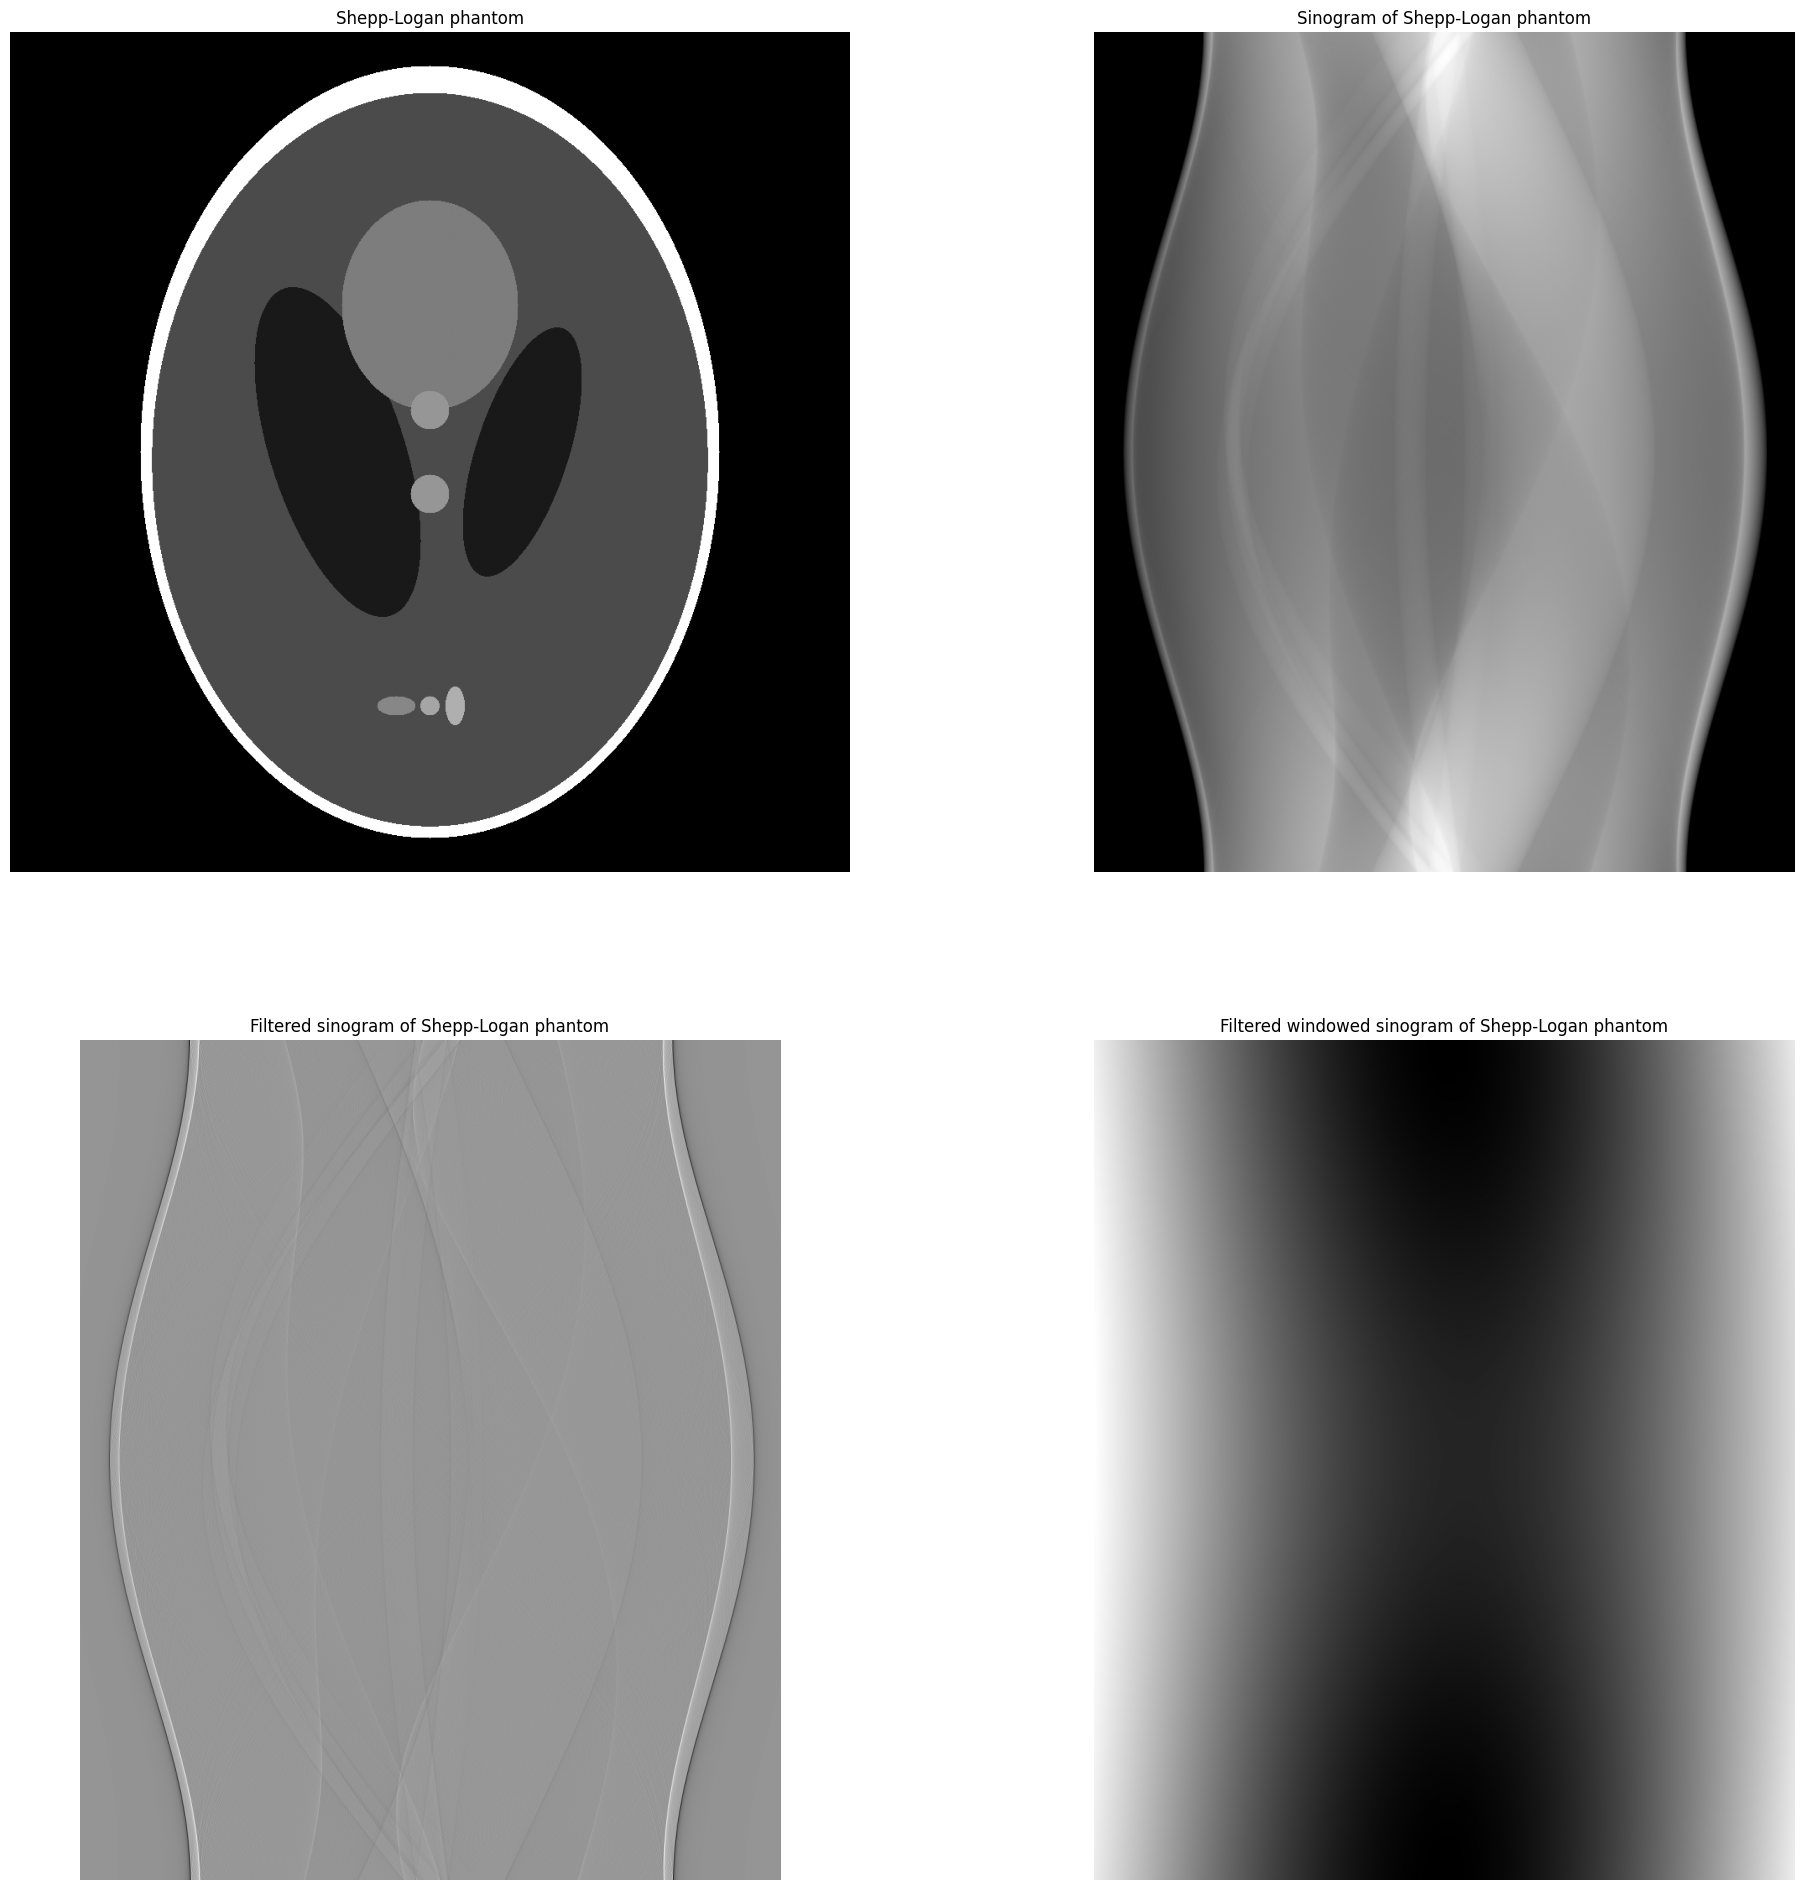

In [6]:
n_proj, n_det = sinogram.shape
n = np.arange(-n_det // 2, n_det // 2)
t = n * tau

filter = DiscreteWindowedRampFilter(tau)
h_t = filter(n)

n_kernel, = h_t.shape

n_fft = n_det + n_kernel - 1

H = np.fft.rfft(h_t, n_fft)
S = np.fft.rfft(sinogram, n_fft, axis=1)

filtered_sinogram = np.fft.irfft(S*H, n_fft, axis=1)

window_time = np.hamming(n_fft)
W = np.fft.rfft(window_time)

filtered_windowed_sinogram = np.fft.irfft(S*H*W, n_fft, axis=1)

start = (n_kernel - 1) // 2
end = start + n_det
filtered_sinogram = filtered_sinogram[:, start:end]
filtered_windowed_sinogram = filtered_windowed_sinogram[:, start:end]

fig, axs = plt.subplots(2,2, figsize=(24, 24))

axs[0,0].imshow(phantom, cmap="gray")
axs[0,0].set_title("Shepp-Logan phantom")
axs[0,0].axis("off")

axs[0,1].imshow(sinogram, cmap="gray")
axs[0,1].set_title("Sinogram of Shepp-Logan phantom")
axs[0,1].axis("off")

axs[1,0].imshow(filtered_sinogram, cmap="gray")
axs[1,0].set_title("Filtered sinogram of Shepp-Logan phantom")
axs[1,0].axis("off")

axs[1,1].imshow(filtered_windowed_sinogram, cmap="gray")
axs[1,1].set_title("Filtered windowed sinogram of Shepp-Logan phantom")
axs[1,1].axis("off")

In [7]:
from reconstruct import interpolate_projections

t_new, sinogram_new = interpolate_projections(t, sinogram, factor=10)

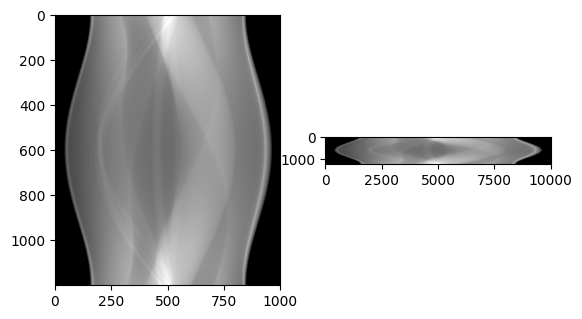

In [8]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(sinogram, cmap="gray")

axs[1].imshow(sinogram_new, cmap="gray")


In [12]:
from tqdm import tqdm

def backprojection(x, y, sinogram, t, theta):
    """Back projects sinogram to reconstruct the original image.

    Parameters
    ----------
        x (float): X index of point to be backprojected.
        y (float): Y index of point to be backprojected.
        sinogram (np.ndarray): Array of projections with shape (n_projections, 
            n_detector_elements).
        t (np.ndarray): Projection axis with shape (n_detector_elements).
        theta (np.ndarray): Array of projection angles with shape (n_projections,).

    Returns
    -------
        (float) : Backprojected value for point (x,y).
    """
    K = len(theta)

    Q_sum = 0
    
    for i, theta_i in enumerate(np.deg2rad(theta)):
        t_corresponding = x*np.cos(theta_i) + y*np.sin(theta_i)
        t_idx = np.argmin(np.abs(t-t_corresponding))

        Q_sum += sinogram[i, t_idx]

    return (np.pi / K) * Q_sum

x = np.arange(-n_pixels // 2, n_pixels // 2)
y = np.arange(-n_pixels // 2, n_pixels // 2)

theta = np.linspace(0, 180, n_projections)

recon = np.zeros_like(phantom)

for i, x_i in tqdm(enumerate(x), desc="Iterating over x axis"):
    for j, y_i in tqdm(enumerate(y), desc="Iterating over y axis"):
        recon[i, j] = backprojection(x_i, y_i, sinogram_new, t_new, theta)

plt.imshow(recon, cmap="gray")

Iterating over x axis: 0it [00:00, ?it/s]

Iterating over y axis: 1001it [01:18, 12.80it/s]
Iterating over y axis: 1001it [01:18, 12.72it/s]
Iterating over y axis: 1001it [01:19, 12.65it/s]
Iterating over y axis: 1001it [01:20, 12.40it/s]
Iterating over y axis: 1001it [01:20, 12.38it/s]
Iterating over y axis: 1001it [01:21, 12.34it/s]
Iterating over y axis: 1001it [01:21, 12.35it/s]
Iterating over y axis: 1001it [01:21, 12.34it/s]
Iterating over y axis: 1001it [01:20, 12.42it/s]
Iterating over y axis: 1001it [01:18, 12.68it/s]
Iterating over y axis: 1001it [01:18, 12.77it/s]
Iterating over y axis: 1001it [01:18, 12.78it/s]
Iterating over y axis: 1001it [01:18, 12.82it/s]
Iterating over y axis: 1001it [01:18, 12.81it/s]
Iterating over y axis: 1001it [01:18, 12.83it/s]
Iterating over y axis: 1001it [01:17, 12.83it/s]
Iterating over y axis: 964it [01:16, 12.68it/s]
Iterating over x axis: 16it [22:25, 84.10s/it]


KeyboardInterrupt: 

In [ ]:
from reconstruct import filter_projections, interpolate_projections, backproject

N = 1001
K = 120
tau = 0.1
factor = 10

phantom = shepp_logan(N)
P_theta = acquire_projections(phantom, n_projections=K, axis="x")
Q_theta = filter_projections(P_theta, tau=0.1)
t = np.arange(-N // 2, N // 2) * tau
t_new, Q_theta_interp = interpolate_projections(t, Q_theta, factor)
recon = backproject(Q_theta_interp, N, t_new, tau)



Theta:  (120,)
X:  (1001, 1001) Y:  (1001, 1001)
$cos(\theta): $ (120, 1, 1) $sin(\theta)$:  (120, 1, 1)
t_corresp:  (120, 1001, 1001)
Index:  (120, 1001, 1001)
Angle_idx:  (120, 1, 1)
Backprojection:  (120, 1001, 1001)


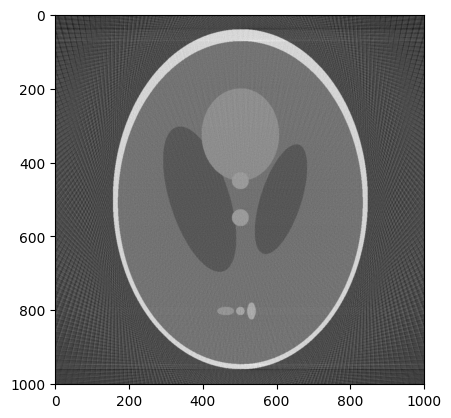

In [30]:
plt.imshow(recon, cmap="gray")

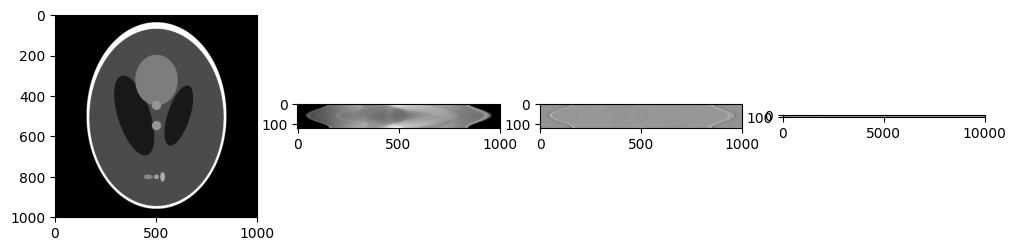

In [20]:
fig, axs = plt.subplots(1,4, figsize=(12, 48))

axs[0].imshow(phantom, cmap="gray")

axs[1].imshow(P_theta, cmap="gray")

axs[2].imshow(Q_theta, cmap="gray")

axs[3].imshow(Q_theta_interp, cmap="gray")


In [21]:
np.mgrid[-N//2:N//2, -N//2:N//2]

array([[[-501, -501, -501, ..., -501, -501, -501],
        [-500, -500, -500, ..., -500, -500, -500],
        [-499, -499, -499, ..., -499, -499, -499],
        ...,
        [ 497,  497,  497, ...,  497,  497,  497],
        [ 498,  498,  498, ...,  498,  498,  498],
        [ 499,  499,  499, ...,  499,  499,  499]],

       [[-501, -500, -499, ...,  497,  498,  499],
        [-501, -500, -499, ...,  497,  498,  499],
        [-501, -500, -499, ...,  497,  498,  499],
        ...,
        [-501, -500, -499, ...,  497,  498,  499],
        [-501, -500, -499, ...,  497,  498,  499],
        [-501, -500, -499, ...,  497,  498,  499]]], shape=(2, 1001, 1001))